# Flat sky power spectrum analysis without masking

If you are dealing with simulated data that is 
1. on a small sky fraction
3. has no unobserved regions
2. periodic on $x$ and $y$

then you can invoke the flat sky approximation without accounting for any masking of the sky. This lets you do a much quicker analysis!

Normally, we decompose the sky into spherical harmonics $Y_{\ell}^m$, but performing a spherical harmonic transform (SHT) can be computationally expensive. On small patches near the equator, the spherical harmonic coefficients from the decomposition resemble those from a Fourier expansion with wavenumbers $k_x$ and $k_y$. In the flat sky limit, the basis functions are related as

$$ k_x \sim m, \quad\quad k_y \sim \sqrt{ \ell(\ell + 1) - m^2 } $$
with $|\mathbf{k}| \sim \ell$. This means you can do an approximate power spectrum analysis using FFTs, which can be orders of magnitude faster than SHTs.

In [1]:
%config InlineBackend.figure_format = 'retina'
from pixell import enmap,curvedsky,utils,powspec,enplot
import numpy as np
import matplotlib.pyplot as plt

## Setting up a map

Let's generate a random map with the three components of the Stokes vector $I$, $Q$, and $U$, with an array of shape $(n_{\mathrm{comp}}, n_{\theta}, n_{\phi})$. If you already have a polarization map, you would use `enmap.read_map` here. I'm using a 10 arcmin pixel.

(119, 217)


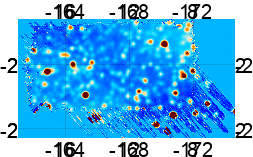

In [2]:
map_I = enmap.read_map("GBT_I.fits")[0,:,:]
shape, wcs = map_I.shape, map_I.wcs

print(map_I.shape)
enplot.show(enplot.plot(map_I, ticks=4))

## Going to Fourier space

We now transform our maps from real space to harmonic space. This approximates the spherical harmonic transform that can be very expensive to perform. We choose the normalization of the FFT to reflect the size of the pixels in the map (a "physical" normalization). This normalization is fixed to ensure the square of the FFT is the power spectrum in units of steradians. 

Pixell follows the common convention of transforming from Stokes $I$, $Q$, $U$ into harmonic space with the $T$, $E$ and $B$ decomposition (you could have represented the spin-2 part in terms of $+$ and $-$ components).

In [3]:
k_map_T = enmap.map2harm(map_I, nthread=0, normalize="phys")

## The 2D TT power spectrum

Let's cross-correlate the T fields! There is a convenience function for performing the convolution (we have applied the usual Fourier cross-correlation theorem $f \star g \sim \mathcal{F}(f) \mathcal{F}(g)^*$). This leaves us with the 2D power spectrum, which computes the power in a mode $k_x, k_y$.

In [4]:
# convenience function for convolution
TT_spec_2D = enmap.calc_ps2d(k_map_T, k_map_T)

Let's plot up the power. I'm plotting $\log| C_{k_x, k_y}|$ so you can see the large variations in power. I'm also applying an FFTshift that just moves the origin to the middle of the picture, instead of the typical FFT ordering where the origin is at the corners.

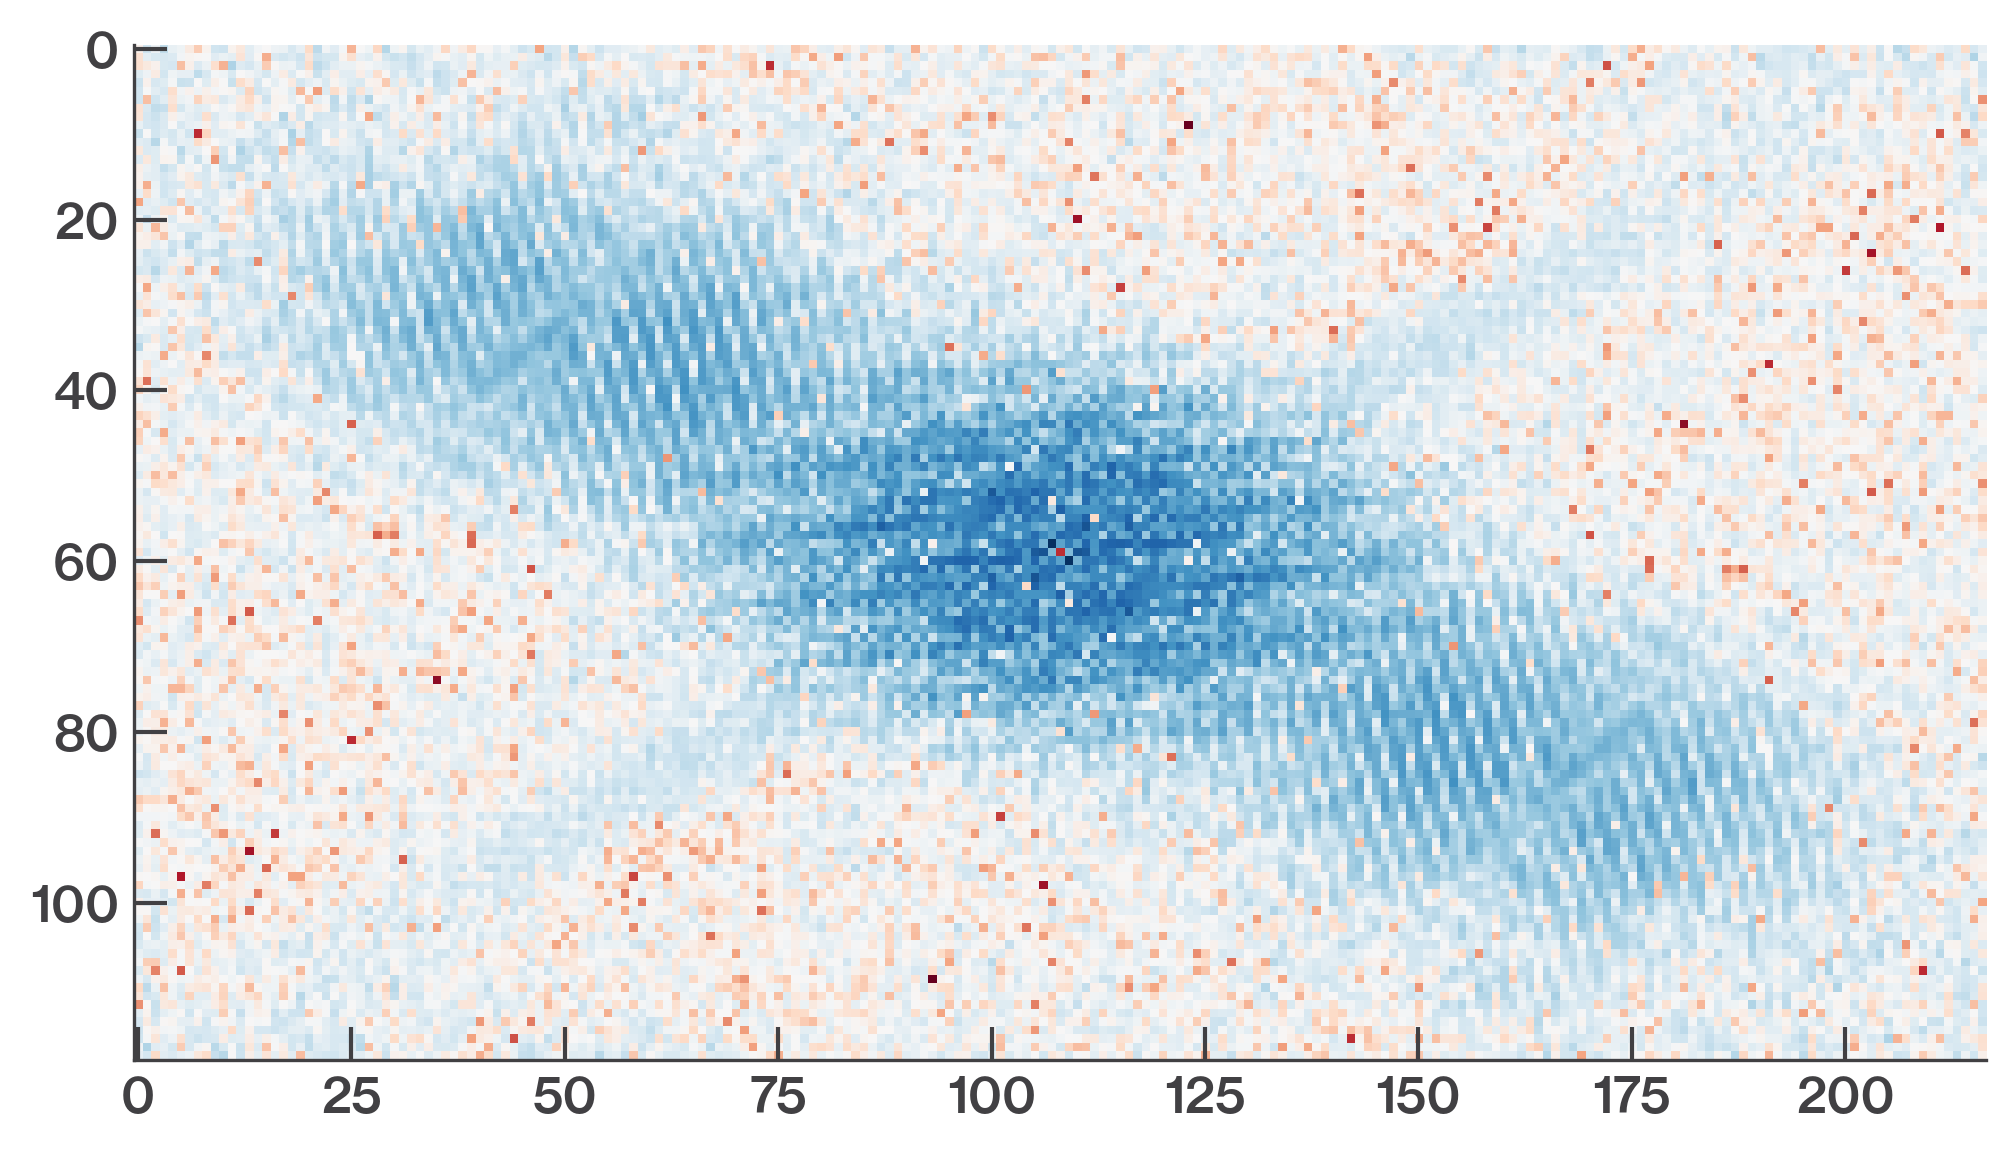

In [5]:
plt.imshow(np.log(np.abs(np.fft.fftshift(TT_spec_2D))), cmap='RdBu')

Note that this image is in the same shape as our image. That's because the Fourier resolution in a dimension depends on the size of the dimension in the real space image.

# Binning it up to make a 1D power spectrum

For an isotropic field, the 2D power spectrum is radially symmetric. Thus, we often present the radially-averaged power spectrum, $C_{|\mathbf{k}|} \sim C_{\ell}$. Typically we would choose a bin size that gives a good balance of signal and noise.

In [6]:
modlmap = TT_spec_2D.modlmap()  # get a map of |𝐤|

In [7]:
def bin(data,modlmap,bin_edges):
    digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
    return np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]

bin_edges = np.arange(0,1000,40)  # 40 bins for ℓ in (0,1000)
ell_bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
binned_power = bin(TT_spec_2D,modlmap,bin_edges)

Text(0.5, 0, 'Multipole moment $\\sim \\ell$')

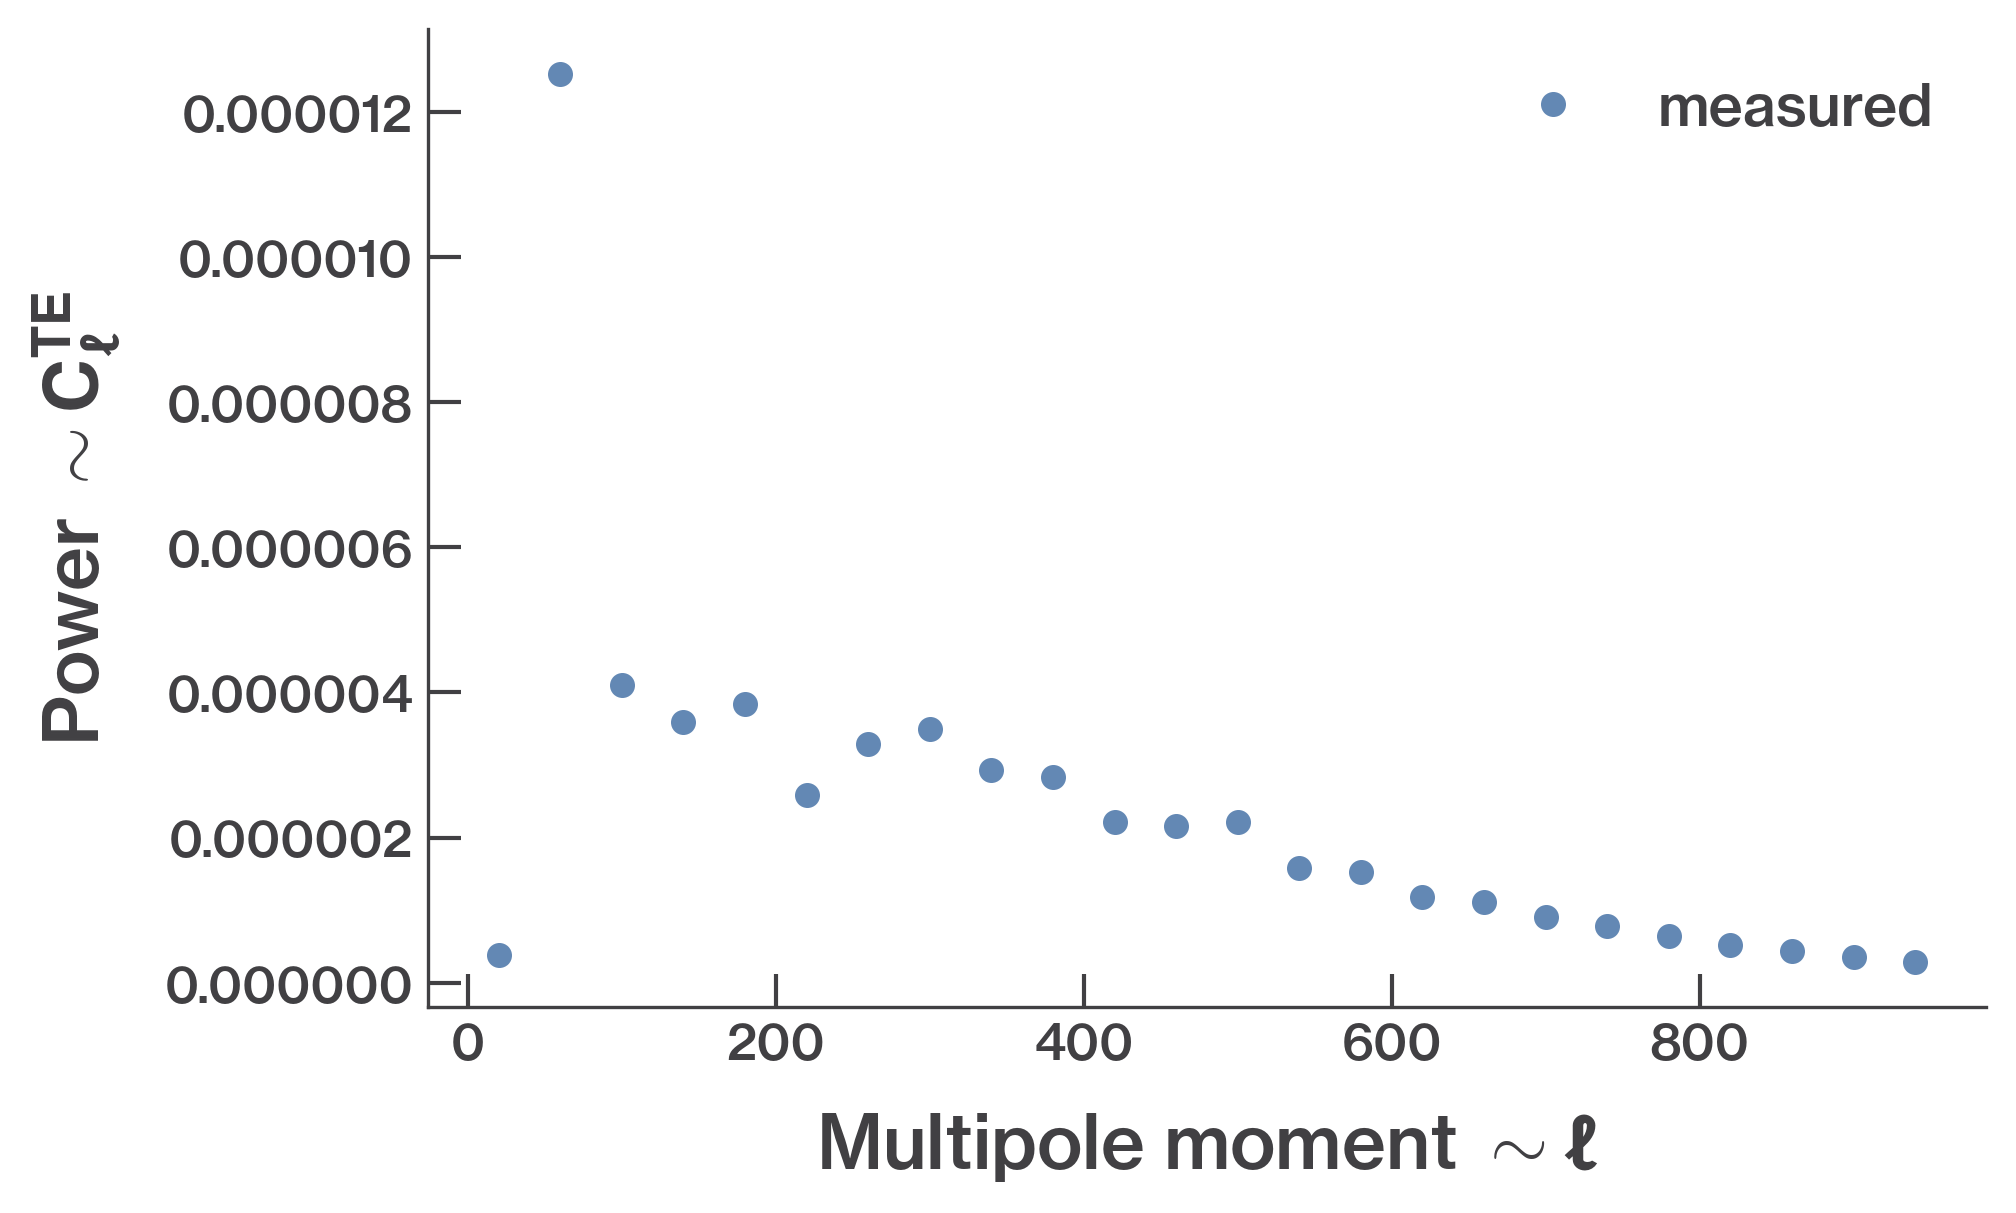

In [8]:
plt.plot(ell_bin_centers, binned_power, "o", label="measured", markersize=5)
plt.legend()
plt.ylabel("Power $\sim C_{\ell}^{TE}$")
plt.xlabel("Multipole moment $\sim \ell$")